# Welcome to the OBD SDD BE!

Today, the goal is to understand how a distributed system can be useful when dealing with medium to large scale data sets.  
We'll see that Dask start to be nice as soon as the Data we need to process doesn't quite fit in memory, but also if we
need to launch several computations in parallel.

In this evaluation, you will:
- Use Dask to read and understand the several gigabytes input dataset in a interactive way,
- Preprocess the data in a distributed way: cleaning it up and adding some useful features,
- Launch some model training that can be parallelized,
- Reduce the dataset and train more accurate models on less Data,
- Do an hyper parameter search to find the best model on a small sample of Data.

In order to run and fill this notebook, you'll need to first deploy a Dask enabled Kubernetes cluster as seen last week. So please use the Kubernetes_DaskHub notebook for the steps to do it. __Be careful, it has been updated to use a Docker image containing ML Libraries since the last time!__.

Once the Jupyterhub is up, you can clone the OBD directory from a Jupyterlab terminal to get this notebook, and select the default kernel.
```
git clone https://github.com/SupaeroDataScience/OBD.git
```

## The Dataset

It is some statistics about NY Taxi cabs. 

See https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview, or https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data.
        
The goal of this evaluation will be to generate a model using machine learning technics that will predict the fare amount
of a taxi ride given the other input parameters we have.

The model will be evaluated using the Root mean squared error algorithm:  
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation.

## Try to analyze the Data using Kaggles'start-up code

As an introduction, we'll use Kaggle starters'code to get some insights on the data set and
computations we'll do and measure pandas library (non parallelized access) performance.

See https://www.kaggle.com/dster/nyc-taxi-fare-starter-kernel-simple-linear-model where this comes from.

On our data set (train and test available in gs://obd-dask), we'll see that with Kaggle method, we don't obtain a really good evaluation.

#### Reading the data with pandas

We're reading only about 20% from the whole data set.

In [36]:
%%time
import pandas as pd
df =  pd.read_csv('gs://obd-dask/train.csv', nrows = 10_000_000)

CPU times: user 21.7 s, sys: 6.75 s, total: 28.5 s
Wall time: 45.1 s


In [37]:
train_df = df
train_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [38]:
from IPython.display import display

display(train_df.head(2), train_df.describe())

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2012-11-09 14:21:00.00000064,9.5,2012-11-09 14:21:00 UTC,-73.973045,40.74403,-73.97274,40.756930,5
1,2013-04-14 19:44:09.0000003,7.5,2013-04-14 19:44:09 UTC,-73.977394,40.68983,-73.97861,40.675716,1


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.000000e+07,1.000000e+07,1.000000e+07,9.999935e+06,9.999935e+06,1.000000e+07
mean,1.133909e+01,-7.250921e+01,3.992044e+01,-7.250870e+01,3.992143e+01,1.685741e+00
std,9.790701e+00,1.291160e+01,9.378093e+00,1.278625e+01,9.417319e+00,1.338361e+00
min,-3.000000e+02,-3.439245e+03,-3.475482e+03,-3.379111e+03,-3.475482e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073492e+01,-7.399141e+01,4.073402e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075314e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076711e+01,-7.396368e+01,4.076808e+01,2.000000e+00
max,9.000000e+02,3.456223e+03,3.376602e+03,3.456223e+03,3.400392e+03,2.080000e+02


#### Analysing dataset, adding some feature and droping null values

Let's see if we can see some links between passenger count and fare amount?

In [39]:
%%time
train_df.groupby(train_df.passenger_count).fare_amount.mean()

CPU times: user 135 ms, sys: 0 ns, total: 135 ms
Wall time: 133 ms


passenger_count
0       9.006352
1      11.210204
2      11.824815
3      11.543991
4      11.771902
5      11.204430
6      12.149398
7      14.500000
8      80.000000
9      32.815000
34     13.300000
49      2.500000
208     9.866667
Name: fare_amount, dtype: float64

Maybe adding some feature about the distance of the trip could be a good idea?

In [40]:
%%time
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(train_df)

CPU times: user 105 ms, sys: 21.1 ms, total: 126 ms
Wall time: 122 ms


Are there some undefined values?

In [41]:
%%time
print(train_df.isnull().sum())

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude     65
dropoff_latitude      65
passenger_count        0
abs_diff_longitude    65
abs_diff_latitude     65
dtype: int64
CPU times: user 1.09 s, sys: 0 ns, total: 1.09 s
Wall time: 1.09 s


In [42]:
%%time
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 10000000
New size: 9999935
CPU times: user 1.99 s, sys: 566 ms, total: 2.56 s
Wall time: 2.55 s


#### Quick analyze on new features and clean outliers

CPU times: user 43.7 ms, sys: 4.44 ms, total: 48.1 ms
Wall time: 44.6 ms


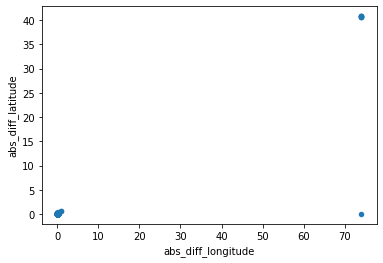

In [43]:
%%time
plot = train_df.iloc[:2000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

In [44]:
%%time
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 5.0) & (train_df.abs_diff_latitude < 5.0)]
print('New size: %d' % len(train_df))

Old size: 9999935
New size: 9979308
CPU times: user 684 ms, sys: 244 ms, total: 929 ms
Wall time: 924 ms


CPU times: user 39.8 ms, sys: 2.63 ms, total: 42.4 ms
Wall time: 37.9 ms


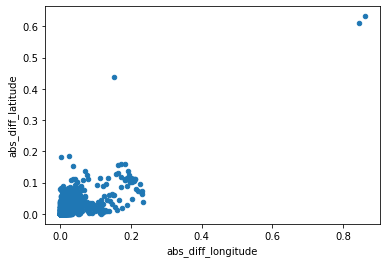

In [45]:
%%time
plot = train_df.iloc[:2000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

#### Get training features and results

In [46]:
import numpy as np

# using the travel vector, plus a 1.0 for a constant bias term.
def get_input_matrix(df):
    return np.column_stack((df.abs_diff_longitude, df.abs_diff_latitude, np.ones(len(df))))

In [47]:
%%time

train_X = get_input_matrix(train_df)
train_y = np.array(train_df['fare_amount'])

print(train_X.shape)
print(train_y.shape)

(9979308, 3)
(9979308,)
CPU times: user 111 ms, sys: 44.5 ms, total: 155 ms
Wall time: 155 ms


In [48]:
train_X[0:2]

array([[3.0500e-04, 1.2900e-02, 1.0000e+00],
       [1.2160e-03, 1.4114e-02, 1.0000e+00]])

#### Train a simple linear model using Numpy

In [49]:
%%time
# The lstsq function returns several things, and we only care about the actual weight vector w.
(w, _, _, _) = np.linalg.lstsq(train_X, train_y, rcond = None)
print(w)

[147.3292454   70.82802188   6.51937826]
CPU times: user 816 ms, sys: 670 ms, total: 1.49 s
Wall time: 741 ms


#### Make prediction on our test set and measure performance

In [50]:
test_df =  pd.read_csv('gs://obd-dask/test.csv')
test_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [51]:
add_travel_vector_features(test_df)
test_X = get_input_matrix(test_df)

In [52]:
test_y_predictions = np.matmul(test_X, w).round(decimals = 2)

In [53]:
test_y_ref = test_df.fare_amount

In [54]:
from sklearn.metrics import mean_squared_error
rmse_pandas_lr = mean_squared_error(test_y_ref, test_y_predictions, squared=False)
rmse_pandas_lr

5.230460641047829

OK, so about 5,23$ of RMSE, this is not that bad... But we can do better.

<span style="color:#EB5E0B;font-style:italic">

### Some questions on this first Analysis

- What is the most expensive part of the analysis, the one that takes the most time (see the %%time we used above)?
</span>

The most expensive part of the analysis is `pd.read_csv()`

<span style="color:#EB5E0B;font-style:italic">
    
- Try to load the whole dataset with Pandas and comment.
</span>

In [ ]:
%%time
pd.read_csv('gs://obd-dask/train.csv')

It is not working

![broken](https://media.giphy.com/media/9RklcGGIioOsg/giphy.gif)

# Processing our data set using dask

Dask will help us processing all the input data set. It is really useful when input data is too big to fit in memory. In this case, it can stream the computation by data blocs one one computer, or distribute the computation on several computers.

This is what we'll do next!

### Start an appropriate sized Dask cluster for our analysis

We'll need a Dask cluster to pre process the data and distribute some learning, the following code starts one in our K8S infrastructure.

In [2]:
from dask_gateway import Gateway
# Use values stored in your local configuration (recommended)
gateway = Gateway()

In [4]:
cluster = gateway.new_cluster(worker_cores=1, worker_memory=3.4)
cluster

__Please click on the Dashboard link above, it will help you a lot!__

In [5]:
client = cluster.get_client()
cluster.scale(16)

### Launch some computation, what about Pi ?

Just to check our cluster is working!

We'll use Dask array, a Numpy extension for this, taht we'll use later on for the Machine Learning part of this evaluation.

In [62]:
%%time
import dask.array as da

sample = 10_000_000_000  # <- this is huge!
xxyy = da.random.uniform(-1, 1, size=(2, sample))
norm = da.linalg.norm(xxyy, axis=0)
summ = da.sum(norm <= 1)
insiders = summ.compute()
pi = 4 * insiders / sample
print("pi ~= {}".format(pi))

pi ~= 3.1415557296
CPU times: user 733 ms, sys: 29.5 ms, total: 762 ms
Wall time: 41.2 s


## Now, access the data of our BE using Dask

We'll use Dask Dataframe, an distributed version of Pandas Dataframe.

See https://docs.dask.org/en/latest/dataframe.html.

<span style="color:#EB5E0B;font-style:italic">

So instead of using Pandas to load the dataset, just use the equivalent dask method from dask.dataframe.

- Fill the following cell with the appropriate code to read the data using Dask.
</span>

In [7]:
import dask.dataframe as dd

In [8]:
%%time
train_df = dd.read_csv('gs://obd-dask/train.csv')

CPU times: user 217 ms, sys: 52.8 ms, total: 270 ms
Wall time: 9.99 s


In [65]:
train_df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
npartitions=85,,,,,,,,
,object,float64,object,float64,float64,float64,float64,int64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


<span style="color:#EB5E0B;font-style:italic">

### Some questions about this data loading

- That was fast for several gigabytes, wasn't it? Why is this, what did we do?
- Why the return dataframe looks empty?
- See the number of partitions described above? What does it correspond to?
</span>

- Yes it was even faster than reading 10M rows with pandas. It just prepare the data structure but don't really load the data.
- Because the data are only load when we need to make operation on them
- It's the number of chunk that `dask.dataframe` used to split the dataset.

## Little warm up: Analyzing our data to better understand it

<span style="color:#EB5E0B;font-style:italic">

- First, how many records do we have? (hint, in python, len() works for almost any object).
</span>

In [13]:
%%time
print(f"There is {len(train_df)} records")

There is 54869617 records
CPU times: user 136 ms, sys: 11 ms, total: 147 ms
Wall time: 13.9 s


In [14]:
%%time
train_df.shape[0].compute()

CPU times: user 31.7 ms, sys: 5.46 ms, total: 37.1 ms
Wall time: 13.8 s


54869617

In [15]:
train_df.shape

(Delayed('int-a1a4869a-8b0a-4749-9dae-da66abea3bd7'), 8)

<span style="color:#EB5E0B;font-style:italic">
    
- What did happend when counting record of our Dask dataframe? Remember with the Spark tutorial: transformations and actions... Same kind of concepts exist in Dask. Just look at the Dask Dashboard!
</span>

It compute the `len` on the 85 chunks and then sum them.

<span style="color:#EB5E0B;font-style:italic">
    
- Compare the time of this computation to the time of loading a subset of the Dataset with Pandas. Was is fast enough considering the number of worker we have?
</span>

Reading 10M rows take 33.8s ($3.38 \mu s/\text{row} $) with `pandas`, computing the lenght of approximately 55M rows take 13s ($0.24 \mu s/\text{row} $) with Dask. So Dask was 14 times faster with 16 workers this seems legit.

### Let's have a look at some data:

In [10]:
%%time
train_df.head()

CPU times: user 11.3 ms, sys: 1.53 ms, total: 12.9 ms
Wall time: 3.92 s


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2012-11-09 14:21:00.00000064,9.5,2012-11-09 14:21:00 UTC,-73.973045,40.744030,-73.972740,40.756930,5
1,2013-04-14 19:44:09.0000003,7.5,2013-04-14 19:44:09 UTC,-73.977394,40.689830,-73.978610,40.675716,1
2,2013-10-12 00:15:00.0000002,7.5,2013-10-12 00:15:00 UTC,-73.994720,40.684770,-73.991110,40.669810,5
3,2012-04-24 18:17:57.0000002,49.8,2012-04-24 18:17:57 UTC,-73.783700,40.646465,-73.976770,40.762363,2
4,2011-09-21 00:59:00.0000003,13.7,2011-09-21 00:59:00 UTC,-73.969000,40.761234,-74.008705,40.705463,1


<span style="color:#EB5E0B;font-style:italic">
    
- Why was it faster than the count records operation above? What did wee read?
</span>

We just read all the values of the 5 first rows so, $8*5=40$ ,values

<span style="color:#EB5E0B;font-style:italic">
    
- Let's compute the mean of the fare given the passenger_count, as we've done with Pandas. Please fill the blank. (hint: don't forget the compute() call)
</span>

In [11]:
%%time
train_df.groupby(train_df.passenger_count).fare_amount.mean().compute()

CPU times: user 62.4 ms, sys: 2.64 ms, total: 65 ms
Wall time: 25 s


passenger_count
0       9.014902
1      11.216303
2      11.838206
3      11.538895
4      11.766858
5      11.207994
6      12.126710
9      36.993043
208     8.975000
8      29.981111
49      2.500000
7      33.559286
34     13.300000
51      9.300000
129     8.900000
Name: fare_amount, dtype: float64

Wow, ever seen a cab with more than 200 people??

<span style="color:#EB5E0B;font-style:italic">

- This is a bit slow, much more than with Pandas, why? Which part of the computation is slow, look at the Dashboard to see the name of the tasks. 
</span>

Because in pandas all the data was already loaded no need to read it for each operation.

The slow part here is `read_csv` which is done on every chunk anf take between 2 and 2.5 s per chunk.

<span style="color:#EB5E0B;font-style:italic">
    
- How could we optimize the next computations ? Where will be the data at the end?
</span>

We could use `persist` to not reload the data for every computations.

In [9]:
train_df = train_df.persist()

<span style="color:#EB5E0B;font-style:italic">
    
- Look at the Dashboard at what is happening beind the scene.
At the end, try again the computation:
</span>

There is no more `read_csv` done for each computation we directly make the operation like in pandas but distributed thanks to Dask.

In [68]:
%%time
train_df.groupby(train_df.passenger_count).fare_amount.mean().compute()

CPU times: user 36.6 ms, sys: 3.43 ms, total: 40 ms
Wall time: 387 ms


passenger_count
0       9.014902
1      11.216303
2      11.838206
3      11.538895
4      11.766858
5      11.207994
6      12.126710
9      36.993043
208     8.975000
8      29.981111
49      2.500000
7      33.559286
34     13.300000
51      9.300000
129     8.900000
Name: fare_amount, dtype: float64

Much better isn't it?

<span style="color:#EB5E0B;font-style:italic">
    
### Some other questions to practice

- Can you see a correlation between the fare amount and the dropoff latitude? Answer by doing a dask dataframe computation.

First you'll need to round the dropoff latitude to have some sort of categories using Series.round() function.

Then, just group_by this new colon to have some answer (and don't forget to compute to get the results).
</span>

In [206]:
train_df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

<AxesSubplot:xlabel='dropoff_latitude_round', ylabel='fare_amount'>

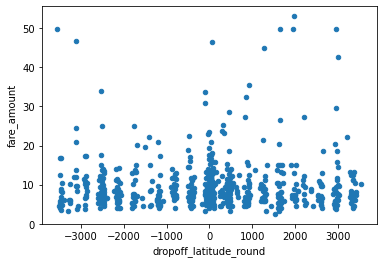

In [10]:
import matplotlib.pyplot as plt
# train_df[["dropoff_latitude",'fare_amount']].loc[:2000].compute().plot(x="dropoff_latitude", y="fare_amount")

train_df["dropoff_latitude_round"] = train_df.dropoff_latitude.round()
train_df.groupby("dropoff_latitude_round")['fare_amount'].mean().compute().reset_index().plot(
    x="dropoff_latitude_round", y="fare_amount", kind="scatter"
)

OK, this don't give a lot of insights, but it looks like we've got some strange values somewhere!

<span style="color:#EB5E0B;font-style:italic">

- Let's just have a look of non extreme values, so probably some records at the middle of the results.
We need first to sort the resulting series by index befor lookin at the middle of it.
</span>

In [208]:
dl_fr = train_df.groupby("dropoff_latitude_round")['fare_amount'].mean().compute().sort_index()
dl_fr

dropoff_latitude_round
-3548.0    49.8
-3494.0     4.5
-3488.0     4.7
-3481.0     4.1
-3475.0    16.9
           ... 
 3378.0    10.5
 3391.0     6.1
 3400.0     8.1
 3407.0     7.3
 3537.0    10.1
Name: fare_amount, Length: 640, dtype: float64

<AxesSubplot:xlabel='dropoff_latitude_round'>

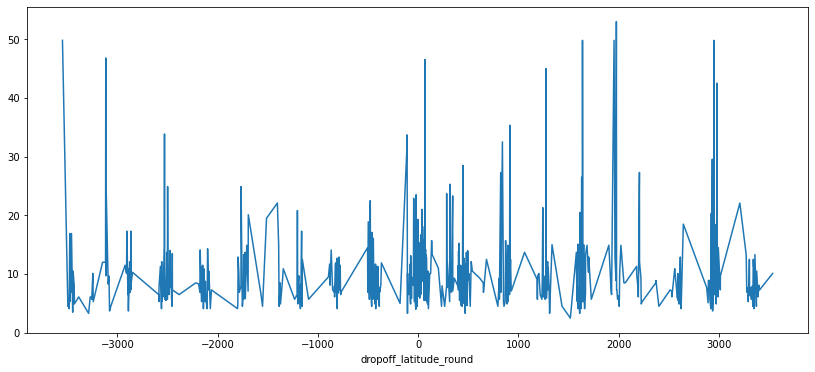

In [209]:
dl_fr.plot()

array([[<AxesSubplot:title={'center':'dropoff_latitude_round'}>,
        <AxesSubplot:title={'center':'fare_amount'}>]], dtype=object)

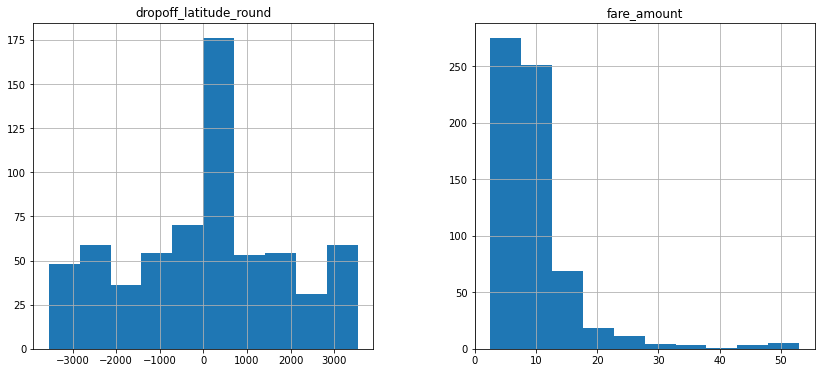

In [210]:
dl_fr.reset_index().hist(figsize=(14,6))

OK, this is not really useful, but it's an exercise!

<span style="color:#EB5E0B;font-style:italic">
    
- Do you think we could parallelize things better for any of our computation or data access?
</span>

Maybe storing the Serie before ploting to avoid making the groupby a second time when sorting.

## Let's do some preprocessing of our data to clean it up and add some features

<span style="color:#EB5E0B;font-style:italic">

- You'll need to do the same operations as in pandas, we just need to call compute when needing a result, and not compute when building our dataframe transformations.
</span>

<span style="color:#EB5E0B;font-style:italic">

#### Cleaning up

- Is there some null values in our data?
</span>

In [14]:
train_df.isna().sum().compute()

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    372
dropoff_latitude     372
passenger_count        0
dtype: int64

<span style="color:#EB5E0B;font-style:italic">
    
- Yep! We must get rid of them...
</span>

In [11]:
%%time
train_df = train_df.dropna(how = 'any')
train_df.isna().sum().compute()

CPU times: user 48.3 ms, sys: 5.48 ms, total: 53.8 ms
Wall time: 2.16 s


key                       0
fare_amount               0
pickup_datetime           0
pickup_longitude          0
pickup_latitude           0
dropoff_longitude         0
dropoff_latitude          0
passenger_count           0
dropoff_latitude_round    0
dtype: int64

#### Adding features

<span style="color:#EB5E0B;font-style:italic">

- As with Pandas above, add the lattitude and longitude distance vector with a function call
</span>

In [12]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

In [13]:
%%time
add_travel_vector_features(train_df)

CPU times: user 17.2 ms, sys: 1.42 ms, total: 18.6 ms
Wall time: 16 ms


A quick look at our Dataframe to check things

In [73]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dropoff_latitude_round,abs_diff_longitude,abs_diff_latitude
0,2012-11-09 14:21:00.00000064,9.5,2012-11-09 14:21:00 UTC,-73.973045,40.744030,-73.972740,40.756930,5,41.0,0.000305,0.012900
1,2013-04-14 19:44:09.0000003,7.5,2013-04-14 19:44:09 UTC,-73.977394,40.689830,-73.978610,40.675716,1,41.0,0.001216,0.014114
2,2013-10-12 00:15:00.0000002,7.5,2013-10-12 00:15:00 UTC,-73.994720,40.684770,-73.991110,40.669810,5,41.0,0.003610,0.014960
3,2012-04-24 18:17:57.0000002,49.8,2012-04-24 18:17:57 UTC,-73.783700,40.646465,-73.976770,40.762363,2,41.0,0.193070,0.115898
4,2011-09-21 00:59:00.0000003,13.7,2011-09-21 00:59:00 UTC,-73.969000,40.761234,-74.008705,40.705463,1,41.0,0.039705,0.055771


<span style="color:#EB5E0B;font-style:italic">
    
- Now let's quickly plot a subset of our travel vector features to see its distribution. Use dask.dataframe.sample() to get about five percent of the rows, and get it back with compute and plot like with Pandas
</span>

In [74]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 6]

array([[<AxesSubplot:title={'center':'abs_diff_longitude'}>,
        <AxesSubplot:title={'center':'abs_diff_latitude'}>]], dtype=object)

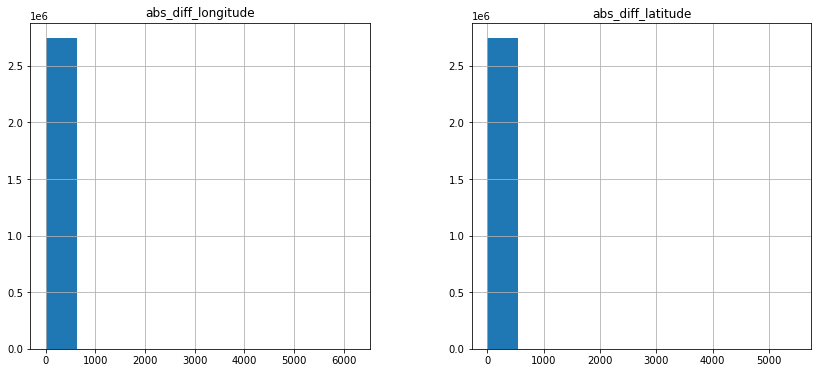

In [75]:
travel_vector_labels=["abs_diff_longitude", "abs_diff_latitude"]
train_df.sample(frac=0.05)[travel_vector_labels].compute().hist()

Wow, looks like we have some strange values here: more than 1000° of distance... There's a problem somewhere.

<span style="color:#EB5E0B;font-style:italic">
    
- Just get rid of the extreme values, we should keep inside the city wall or so. Like with Pandas.
</span>

In [76]:
train_df[travel_vector_labels].sample(frac=0.05).compute().describe()

,abs_diff_longitude,abs_diff_latitude
count,2.743458e+06,2.743458e+06
mean,2.054149e-01,1.240787e-01
std,1.088427e+01,9.166923e+00
min,0.000000e+00,0.000000e+00
25%,5.800000e-03,6.580000e-03
50%,1.243000e-02,1.385700e-02
75%,2.371000e-02,2.695100e-02
max,6.211753e+03,5.486099e+03


In [14]:
%%time
train_df_filter = train_df[
    (train_df['abs_diff_longitude'] < 0.5) & (train_df['abs_diff_latitude'] < 0.5)
]

CPU times: user 3.47 ms, sys: 0 ns, total: 3.47 ms
Wall time: 3.37 ms


CPU times: user 480 ms, sys: 121 ms, total: 601 ms
Wall time: 3.38 s


array([[<AxesSubplot:title={'center':'abs_diff_longitude'}>,
        <AxesSubplot:title={'center':'abs_diff_latitude'}>]], dtype=object)

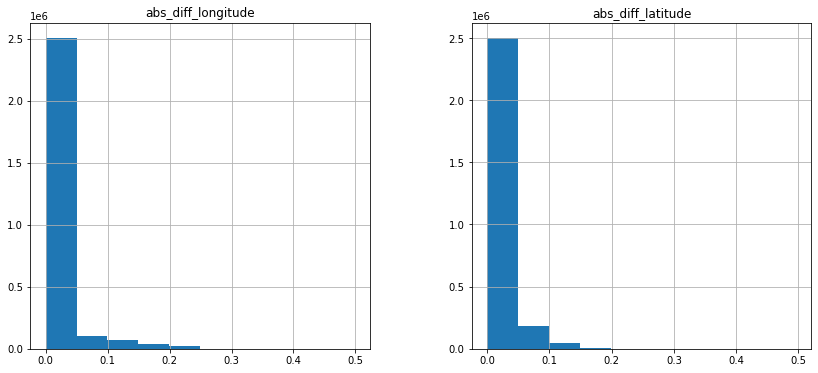

In [78]:
%%time
train_df_filter.sample(frac=0.05)[travel_vector_labels].compute().hist()

<span style="color:#EB5E0B;font-style:italic">
    
- What is triggering the computation in the examples above?
</span>

It's the `.compute()`

<span style="color:#EB5E0B;font-style:italic">

- you can do another plot like above with the filtered values if you like.
</span>

See plot above

Ok, let's see some statistics on our Dataset. The describe() function inherited from Pandas compute a lot of statistics on a dataframe.

In [15]:
# Use filtered dataframe for now on
train_df = train_df_filter

In [80]:
%%time
train_df.describe().compute()

CPU times: user 1.35 s, sys: 10.5 ms, total: 1.36 s
Wall time: 10.1 s


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dropoff_latitude_round,abs_diff_longitude,abs_diff_latitude
count,5.473521e+07,5.473521e+07,5.473521e+07,5.473521e+07,5.473521e+07,5.473521e+07,5.473521e+07,5.473521e+07,5.473521e+07
mean,1.133046e+01,-7.257237e+01,3.995257e+01,-7.257149e+01,3.995296e+01,1.685537e+00,4.019680e+01,2.224811e-02,2.083720e-02
std,2.077880e+01,1.095309e+01,7.042641e+00,1.095298e+01,7.042696e+00,1.327086e+00,7.070518e+00,3.356557e-02,2.297478e-02
min,-3.000000e+02,-3.440697e+03,-3.488080e+03,-3.440697e+03,-3.488080e+03,0.000000e+00,-3.488000e+03,0.000000e+00,0.000000e+00
25%,6.000000e+00,-7.399202e+01,4.073515e+01,-7.399136e+01,4.073423e+01,1.000000e+00,4.100000e+01,5.959750e-03,6.662500e-03
50%,8.500000e+00,-7.398175e+01,4.075282e+01,-7.398010e+01,4.075332e+01,1.000000e+00,4.100000e+01,1.250450e-02,1.401600e-02
75%,1.250000e+01,-7.396703e+01,4.076722e+01,-7.396363e+01,4.076821e+01,2.000000e+00,4.100000e+01,2.392625e-02,2.697850e-02
max,9.396336e+04,3.456223e+03,3.378013e+03,3.456223e+03,3.378013e+03,2.080000e+02,3.378000e+03,4.999390e-01,4.994500e-01


<span style="color:#EB5E0B;font-style:italic">
    
- Are there some values that still looks odd to you in here?
</span>

Yes some records with more than 8 passengers, and some with very high prices !

## Training a model in a distributed way

Let's begin with a linear model that we can distributed with Dask ML.

### Building our feature vectors

Here again define a method so that we can use it later for our test set evaluation.

<span style="color:#EB5E0B;font-style:italic">
    
- Just do the same as with the Pandas example by defining a get_input_matrix(df) function. But this time you'll generate a dask array using to_dask_array(length=True) method on the dataframe. You should do a method that generate the X input features dask array, and also the same with y training results. You can do just one method that return both. 
- It is a good idea to persist() arrays in memory in or after the call.
- This time, we'll add the feature 'passenger_count' in addition to the distance vectors.
</span>

In [16]:
def get_input_matrix(df, xlabels=["abs_diff_longitude", "abs_diff_latitude", "passenger_count"], ylabel="fare_amount"):
    X = df[xlabels].to_dask_array(lengths=True)
    y = df[ylabel].to_dask_array(lengths=True)
    return X, y

Then we get the values, and display train_X to have some insights of its size and chunking scheme.

In [17]:
train_X, train_y = get_input_matrix(train_df)
display(train_X, train_y)

dask.array<values, shape=(54735207, 3), dtype=float64, chunksize=(651497, 3), chunktype=numpy.ndarray>

dask.array<values, shape=(54735207,), dtype=float64, chunksize=(651497,), chunktype=numpy.ndarray>

### Distributed training a Linear model

Be careful, this can take time, try first with few iterations (max_iter = 5).

see https://ml.dask.org/glm.html  
and https://ml.dask.org/modules/generated/dask_ml.linear_model.LinearRegression.html#dask_ml.linear_model.LinearRegression

<span style="color:#EB5E0B;font-style:italic">
    
- Train a LinearRegression model from dask_ml.linear_model on our inputs
</span>


In [84]:
from dask_ml.linear_model import LinearRegression

In [93]:
%%time
lr = LinearRegression(max_iter=1)
lr.fit(train_X, train_y)

CPU times: user 377 ms, sys: 12.1 ms, total: 389 ms
Wall time: 12.3 s


LinearRegression(max_iter=1)

## Evaluating our model


#### First we should load the test set.

In [18]:
test_df = dd.read_csv('gs://obd-dask/test.csv')
test_df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
npartitions=1,,,,,,,,
,object,float64,object,float64,float64,float64,float64,int64
,...,...,...,...,...,...,...,...


Adding our features to the test set and getting our feature array

In [30]:
add_travel_vector_features(test_df)
test_X, test_y = get_input_matrix(test_df)
test_X

dask.array<values, shape=(535627, 3), dtype=float64, chunksize=(535627, 3), chunktype=numpy.ndarray>

We can use the score method inherited from Scikit learn, it gives some hints on the model performance.

In [96]:
lr.score(test_X, test_y)

0.4419665288406154

Just get the numpy arrays for computing final score, this is small.

In [31]:
%%time
test_X = test_X.compute()
test_y = test_y.compute()

CPU times: user 39.1 ms, sys: 31 ms, total: 70 ms
Wall time: 3.91 s


In [98]:
lr.predict(test_X)

array([10.04454301,  9.83068925,  9.19535567, ...,  6.52536213,
       13.6222112 ,  7.81943548])

#### Compute the RMSE

https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation

In [99]:
from sklearn.metrics import mean_squared_error
rmse_dask_lr = mean_squared_error(test_y, lr.predict(test_X), squared=False)
rmse_dask_lr

5.77095154598194

<span style="color:#EB5E0B;font-style:italic">
    
- What RMSE did you get? Compare it to the Pandas only computation.
</span>

In [100]:
pd.DataFrame([rmse_pandas_lr, rmse_dask_lr], index=["pandas", "dask"], columns=["RMSE"])

,RMSE
pandas,5.230461
dask,5.770952


We get similar result than the one with pandas wich seem normal since we just use simple Linear model. But the good point is that we were able to deal with 55M of rows pretty fast.

![fast](https://media.giphy.com/media/lRnUWhmllPI9a/giphy.gif)

<span style="color:#EB5E0B;font-style:italic">
    
- Why is this model not really good?
</span>

The assumption that price is linear with distance is not so true. When there is traffic price is calculated according to the time spent in the taxi and not the distance, also price sometimes change according to the time in the day.

## Use Dask to scale computation on Hyper Parameter Search

As seen above, Dask is well suited to distribute Data and learn a model on a big Data set. However, not all the models can be train in parallel on sub chunks of Data. See https://scikit-learn.org/stable/computing/scaling_strategies.html for the compatible models of Sickit learn for example.

Dask can also be used to train several model in parallel on small datasets, this is what we'll try now.

We will just take a sample of the training set, and try to learn several models with different hyper parameters, and find the best one.

Dask Hyper parameter search : https://ml.dask.org/hyper-parameter-search.html.

First we'll take a small subset of the Data, 5% is a maximum if we want to avoid memory issues on our workers and have appropriate training times. You can try with less if the results are still good.

In [19]:
%%time
#Take a sample of the input data, get it as pandas dataframe
train_sample_df = train_df.sample(frac=0.05, random_state=21)
# Get feature vectors out of it
train_sample_X, train_sample_y = get_input_matrix(train_sample_df)

CPU times: user 238 ms, sys: 27.4 ms, total: 265 ms
Wall time: 5.29 s


In order to optimize things, we can also change the type of the features to more appropriate and small types.

We also need to use Numpy arrays, so we'll gather the result from Dask to local variable.

In [20]:
train_sample_X = train_sample_X.astype('float32').compute()
train_sample_y = train_sample_y.astype('float32').compute()
train_sample_X, train_sample_y

(array([[2.1784e-02, 1.8567e-02, 1.0000e+00],
        [1.5739e-02, 1.8718e-02, 1.0000e+00],
        [7.9600e-04, 6.4930e-03, 1.0000e+00],
        ...,
        [3.9600e-02, 4.7600e-02, 1.0000e+00],
        [2.6169e-02, 6.5689e-02, 1.0000e+00],
        [2.0064e-02, 1.8310e-03, 1.0000e+00]], dtype=float32),
 array([10.5,  6.1,  4.5, ..., 21. , 18.5,  6.5], dtype=float32))

What size is our dataset ?

In [103]:
import sys
sys.getsizeof(train_sample_X)

32841196

About 32MB, this is still quite a big dataset for standard machine learning.

<span style="color:#EB5E0B;font-style:italic">

- Now, just use dask hyper parameter search Dask API to distribute the search. You can either use joblib integration with Sklearn or dask_ml directly. Be careful: do not use model too long to train, and limit their complexity at first or the combinations of hyper parameters you'll use. Hint, start first with a simple LinearModel like SGDRegressor and not more than 10 iterations per model.
</span>

In [35]:
import dask.distributed
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import joblib

In [83]:
%%time

model = SGDRegressor(max_iter = 10)

param_grid = {
    #'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'loss': ['squared_loss', 'huber'],
    'alpha' : [0.0001, 0.00001]
}

search = GridSearchCV(model, param_grid, verbose=2, cv=5, n_jobs = -1)

CPU times: user 248 µs, sys: 0 ns, total: 248 µs
Wall time: 415 µs


In [84]:
%%time
with joblib.parallel_backend("dask", scatter=[train_sample_X, train_sample_y]):
    search.fit(train_sample_X, train_sample_y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 39.5 s, sys: 6.94 s, total: 46.4 s
Wall time: 1min 45s


In [85]:
search.score(test_X, test_y)

0.44089058552326077

In [86]:
search.best_params_

{'alpha': 1e-05, 'loss': 'squared_loss'}

In [87]:
mean_squared_error(test_y, search.predict(test_X), squared=False)

5.776512347401998

<span style="color:#EB5E0B;font-style:italic">

- So how does the result compare to distributed leaning with a linear model? On all the dataset?
    
</span>

Even with the changed hyperparameters, the mean squared error and the regressor scores seem to be equals. Let's try the Random Forest Regressor : a more complex model.

<span style="color:#EB5E0B;font-style:italic">
    
- Can you do better with Random forest? Caution: use limited trees, small number of estimators < 5 and max_depth < 40...
</span>

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [37]:
%%time
model = RandomForestRegressor()

param_grid = {
    'n_estimators' : [3, 5],
    'max_depth' : [15, 30]
}

search = GridSearchCV(model, param_grid, verbose=2, cv=3, n_jobs = -1)

CPU times: user 105 µs, sys: 26 µs, total: 131 µs
Wall time: 135 µs


In [38]:
%%time
with joblib.parallel_backend("dask", scatter=[train_sample_X, train_sample_y]):
    search.fit(train_sample_X, train_sample_y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
CPU times: user 799 ms, sys: 239 ms, total: 1.04 s
Wall time: 55 s


In [39]:
search.score(test_X, test_y)

0.7487589452990193

In [40]:
search.best_params_, search.best_score_

({'max_depth': 15, 'n_estimators': 5}, 0.7420836479147336)

In [41]:
mean_squared_error(test_y, search.predict(test_X), squared=False)

3.8722430359055076

<span style="color:#EB5E0B;font-style:italic">
    
- Did you get better results with RandomForest? Why ?
</span>

Yes, the model matches better with the dataset. The score reaches more than 0.7 for a given couple of hyperparameters.

Maybe because it allows to better explore the feature.

We also observe that RandomForest allows to use many task by building a lot of trees in parralel.

<span style="color:#EB5E0B;font-style:italic">
    
# Extend this notebook
    
Try to do better!

- Add new features to the input Data using Dask Dataframes, or clean it better. Reapply the learning above with these new features. Do you get better results? Some suggestions for a better leaning:
  - Max passenger count of 208, maybe we should ignore this value? Rides with 0 passengers? Try to drop some data.
  - Apply some normalisation or regularization or other feature transformation? See https://ml.dask.org/preprocessing.html.
  - There are 0m rides?
  - Negative fare amount?? Drop some data.
  - Maybe the hour of the day, or the month, has some impact on fares? Try to add features. See https://matthewrocklin.com/blog/work/2017/01/12/dask-dataframes for some hints on how to do this.
  - Maybe try to find a way to use the start and drop off locations?
- Improve the model parameters or find a better one. Try using this time dask_ml HyperbandSearchCV. See https://ml.dask.org/hyper-parameter-search.html#basic-use. You can use it for example with https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor.

</span>
